In [330]:
## BEAMMAP Class codebase: going from the time domain to the position/map domain

from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
import hdf5plugin
import os
import glob
from matplotlib import colors
import pandas
import csv
import datetime
import pytz
import bisect
import pygeodesy
import yaml
from scipy.signal import square
from scipy.stats import pearsonr

## Import packages from our own module:
from beamcals import corr
from beamcals import drone
from beamcals import bicolog
from beamcals import concat
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site

d3asite=site.site('../beamcals/beamcals/sites/D3A_3m_config.npz')

Initializing Correlator Class using:
  --> /media/tyndall/extradrive1/D3A_data/20221103T233347Z_D3A/corr/20221103T233359Z/
  --> Arrays initialized with shape (399, 64, 1024, 4)
Assigning array values by reading in data files:
  --> Loading File: 0398/0398
  --> Finished. Reshaping arrays.
Initializing drone data via datcon_csv routine: FLY777.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 17079/17079 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
Initializing CONCAT CLASS with active traceback using:
  --> /media/tyndall/extradrive1/D3A_data/20221103T233347Z_D3A/corr/20221103T233359Z/
  --> FLY777.csv
  --> Traceback outputs will not be saved...
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator 

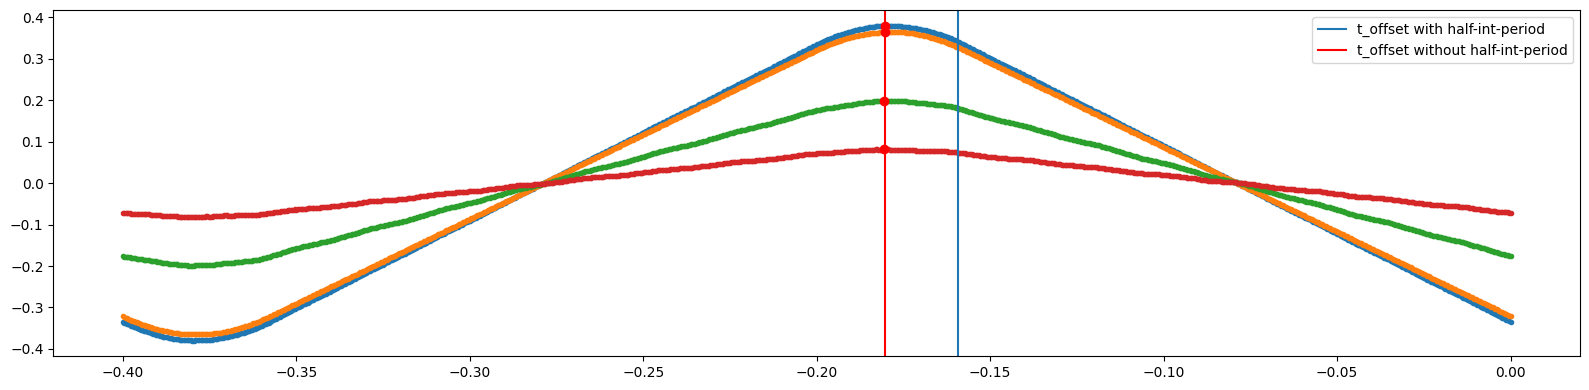

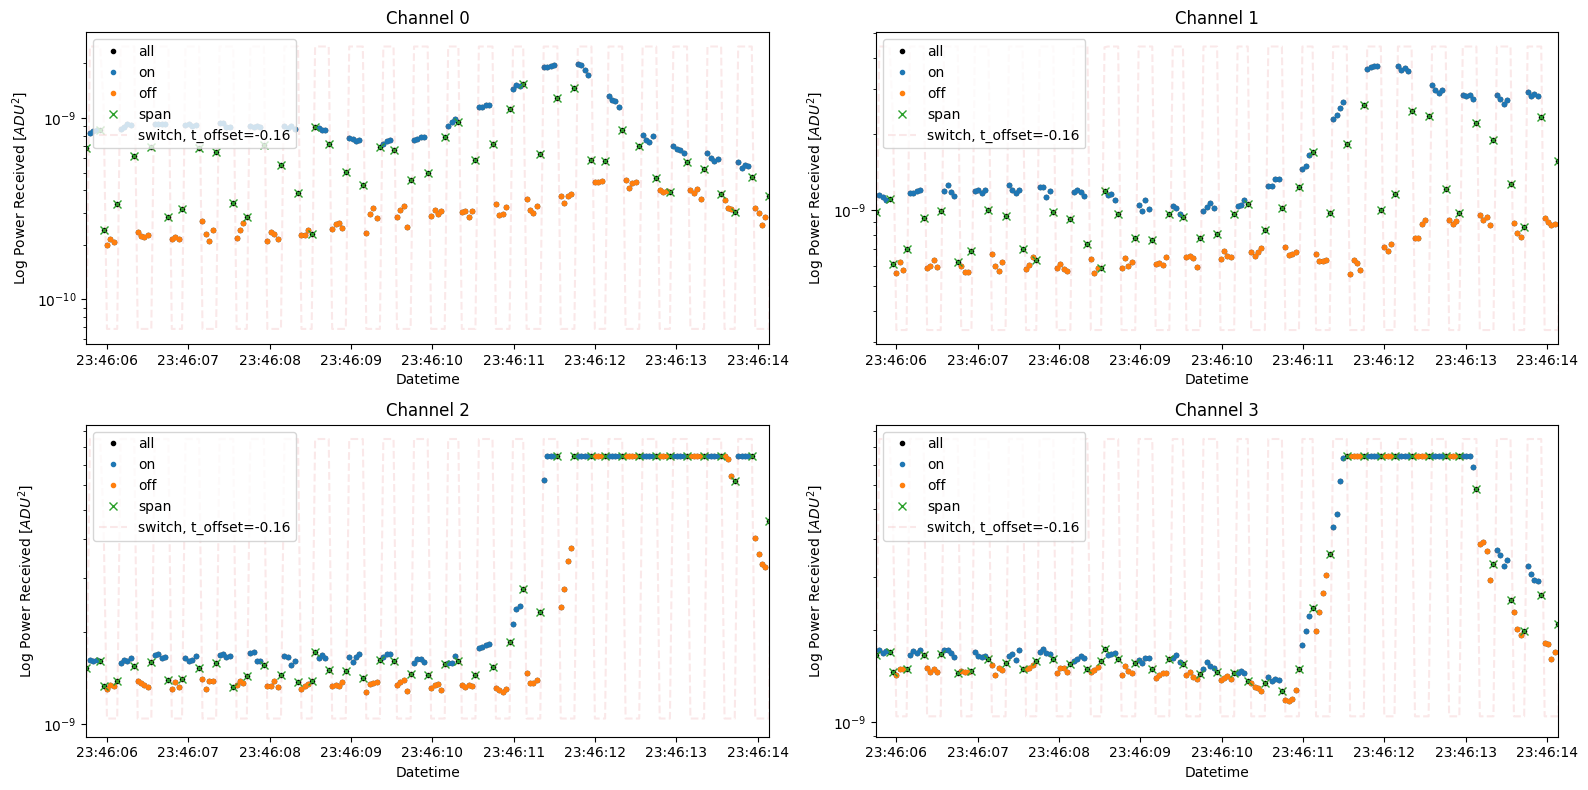

In [294]:
gaindir='/media/tyndall/extradrive1/D3A_data/digital_gains/20221103T233347Z_D3A_digitalgain/'
datadir='/media/tyndall/extradrive1/D3A_data/20221103T233347Z_D3A/corr/20221103T233359Z/'
nfcorr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=d3asite,crossmap=[1])

dronedir="/media/tyndall/extradrive1/20221031_D3A_DJI_Data/"
nfdrone=drone.Drone_Data(dronedir,'FLY777.csv',site_class=d3asite)

nfconcat=concat.CONCAT(CORRDATCLASS=nfcorr,DRONEDATCLASS=nfdrone,\
                       config_directory="/media/tyndall/extradrive1/D3A_data/outputs/",\
                       output_directory="/media/tyndall/extradrive1/D3A_data/outputs/",\
                       load_yaml=False,save_traceback=False)
#nfconcat.t_delta_pulse=-.17
## Use the Extract_Source_Pulses and Perform_Background_Subtraction functions: (NO PULSING!)
nfconcat.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[10000,10200],f_ind=900)
nfconcat.Perform_Background_Subtraction(window_size=10)
#nfconcat.Export_yaml()
#nfconcat.Main_Beam_Fitting()

[12, 17] [795.3125   793.359375]


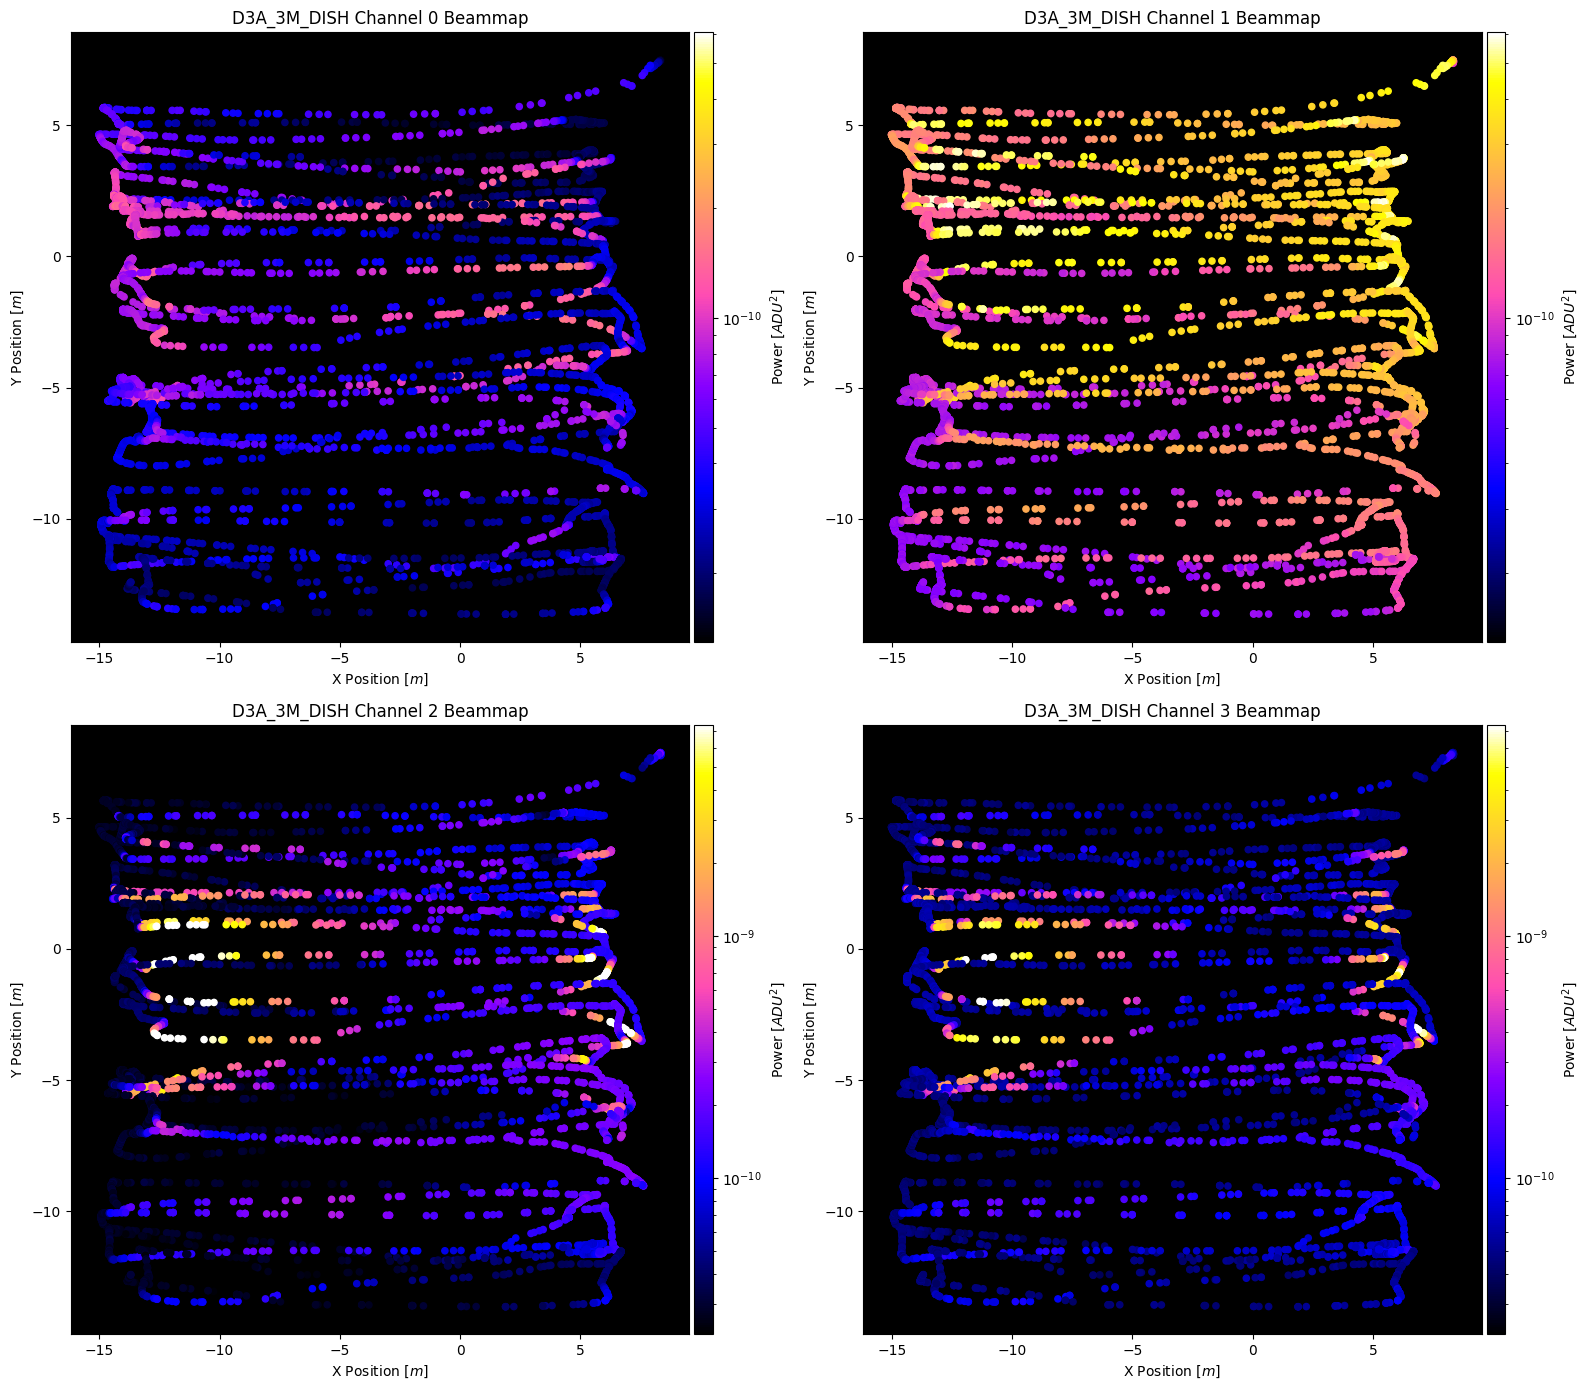

In [295]:
tbds=[6700,21400]
#tbds=[0,-1]
tlb,tub=tbds
for k in np.sort(np.concatenate((np.arange(12,1022,17),np.arange(17,1022,17)))).reshape(60,2).tolist()[:1]:
    print(k,nfconcat.freq[k])
    pu.Plot_Beammap(concat_class=nfconcat,t_bounds=[tbds[0],tbds[1]],\
                    pulse_args='on',coord_args='LC',dotsize=20,f_bounds=[k[0],k[1]])

In [343]:
testbeam.x_edges.shape+(1,)
len(xedges)
d3asite.coords
nfconcat.dish_coords
np.outer(xedges,np.ones(21)).shape
nfconcat.dish_coords[:,0]
nfconcat.name


'D3A_3M_DISH'

In [313]:
## Class for position-space sorting/averaging of beammap flight data, from time domain data:
print(d3asite.keystrings)
#defines coordinate vector from xmax to xmin spaced roughly by xres:
def cedges(args):
    cmin,cmax,cres=args
    return np.linspace(cmin,cmax,int((cmax-cmin)/cres)+1)

class Beammap:
    def __init__(self,concatlist=[],operation='coadd',Xargs=[-100,100,1],Yargs=[-100,100,1]):
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        self.operation=operation
        xedges,yedges=(cedges(Xargs),cedges(Yargs))
        xedgesgrid,yedges_grid=np.meshgrid(self.x_edges,self.y_edges)
        xcenters,ycenters=(cedges(Xargs)[:-1]+Yargs[2]/2.0,cedges(Yargs)[:-1]+Yargs[2]/2.0)
        xcentersgrid,ycentersgrid=np.meshgrid(self.x_centers,self.y_centers)
        #need to extend this to dimensionality of channels in concatclass.V
            # This change means all compared concats in concatlist should have the same n_channels
        self.x_edges=np.zeros(xedges.shape+(len(CONCATCLASS.V_bgsub.shape[2]),))
        self.y_edges=np.zeros(yedges.shape+(len(CONCATCLASS.V_bgsub.shape[2]),))
        self.x_edges_grid=np.zeros((xedgesgrid.shape+(len(CONCATCLASS.V_bgsub.shape[2]),)))
        self.y_edges_grid=np.zeros((yedgesgrid.shape+(len(CONCATCLASS.V_bgsub.shape[2]),)))
        self.x_centers=np.zeros(xcenters.shape+(len(CONCATCLASS.V_bgsub.shape[2]),))
        self.y_centers=np.zeros(ycenters.shape+(len(CONCATCLASS.V_bgsub.shape[2]),))
        self.x_centers_grid=np.zeros((xcentersgrid.shape+(len(CONCATCLASS.V_bgsub.shape[2]),)))
        self.y_centers_grid=np.zeros((ycentersgrid.shape+(len(CONCATCLASS.V_bgsub.shape[2]),)))
        for i in range(CONCATCLASS.V_bgsub.shape[2]):
            if 'D3A' in CONCATCLASS.name:
                xoff=CONCATCLASS.dish_coords[i][0]
                yoff=CONCATCLASS.dish_coords[i][1]
            elif 'GBO' in CONCATCLASS.name:
                xoff=CONCATCLASS.dish_coords[i][0]
                yoff=CONCATCLASS.dish_coords[i][1]
            self.x_edges[:,i]=xedges+xoff
            self.x_centers[:,i]=xcenters+xoff
            self.y_edges[:,i]=yedges+yoff
            self.y_centers[:,i]=ycenters+yoff
            self.x_centers_grid[:,:,i]
            self.y_centers_grid[:,:,i]
            self.x_edges_grid[:,:,i]
            self.y_edges_grid[:,:,i]        
        
        #get variables that should be kept along from the first concat class:    
        CONCATCLASS=concatlist[0]
        self.name=CONCATCLASS.name
        self.Data_Directory=CONCATCLASS.Data_Directory
        self.Gain_Directory=CONCATCLASS.Gain_Directory
        self.filenames=CONCATCLASS.filenames
        self.gainfile=CONCATCLASS.gainfile
        self.Drone_Directory=CONCATCLASS.Drone_Directory
        self.FLYTAG=CONCATCLASS.FLYTAG
        self.n_dishes=CONCATCLASS.n_dishes
        self.n_channels=CONCATCLASS.n_channels
        self.chmap=CONCATCLASS.chmap
        self.automap=CONCATCLASS.automap
        self.crossmap=CONCATCLASS.crossmap
        self.origin=CONCATCLASS.origin
        self.prime_origin=CONCATCLASS.prime_origin
        self.dish_keystrings=CONCATCLASS.dish_keystrings
        self.dish_coords=CONCATCLASS.dish_coords
        self.dish_pointings=CONCATCLASS.dish_pointings
        self.dish_polarizations=CONCATCLASS.dish_polarizations
        self.freq=CONCATCLASS.freq
        self.V_LC_mean=np.NAN*np.ones((self.x_centers_grid.shape[0],self.x_centers_grid.shape[1],\
                                  CONCATCLASS.V_bgsub.shape[1],CONCATCLASS.V_bgsub.shape[2],len(concatlist)))
        self.V_LC_std=np.NAN*np.ones((self.x_centers_grid.shape[0],self.x_centers_grid.shape[1],\
                                      CONCATCLASS.V_bgsub.shape[1],CONCATCLASS.V_bgsub.shape[2],len(concatlist)))
        self.histogram_LC=np.NAN*np.ones((self.x_centers_grid.shape[0],self.x_centers_grid.shape[1],\
                                          CONCATCLASS.V_bgsub.shape[2],len(concatlist)))
        #loop through the concat classes (ccc=concatclass) and extract hist/V parameters:
        for h,ccc in enumerate(concatlist):
            for i,chan in enumerate(self.chmap):
                x,y=[ccc.drone_xyz_per_dish_interp[i,:,0],ccc.drone_xyz_per_dish_interp[i,:,1]]
                histo2d,xbins,ybins=np.histogram2d(x=x,y=y,bins=[self.x_edges,self.y_edges])
                self.histogram_LC[:,:,i,h]=histo2d
                xnz,ynz=np.where(histo2d!=0)
                for m in range(len(xnz)):
                    j,k=[xnz[m],ynz[m]]
                    xacc=np.intersect1d(np.where(self.x_edges[j]<=x),np.where(self.x_edges[j+1]>x))
                    yacc=np.intersect1d(np.where(self.y_edges[k]<=y),np.where(self.y_edges[k+1]>y))
                    tacc=np.intersect1d(xacc,yacc)
                    self.V_LC_mean[j,k,:,i,h]=np.nanmean(ccc.V_bgsub[tacc,:,i],axis=0)
                    self.V_LC_std[j,k,:,i,h]=np.nanstd(ccc.V_bgsub[tacc,:,i],axis=0)
## Ongoing issues/targets: n_dishes degeneracy in siteclass --> move to channel based approach...
## Laura's Objectives:
## X - standard deviation 
## gaussian normalization, centroid matching, & radial binning: laura's gaussian fitting ipynb
## Polar transformation
## Interpolation
## Slices in coordinates: x,y,theta,phi
## Add/Subtract/
## Danny Jacobs: Sometimes you dont want to localize to a single point, some gridding is nearest-neighbors?
            
print(nfconcat.drone_xyz_per_dish_interp.shape)


testbeam=Beammap(concatlist=[nfconcat],Xargs=[-20,10,1],Yargs=[-20,10,1])
print(testbeam.operation)

        
#nfdrone.xyz_per_dish.shape
#nfconcat.drone_xyz_per_dish_interp.shape
print(testbeam.x_centers_grid.shape,testbeam.x_edges_grid.shape)
testbeam.histogram_LC.shape
print(d3asite.coords)

['D3A_3m' 'D3A_3m_rfof' 'W_Bico' 'N_Bico']
(4, 25536, 3)
coadd
(30, 30) (31, 31)
[[-4.  0.  0.]
 [ 4.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


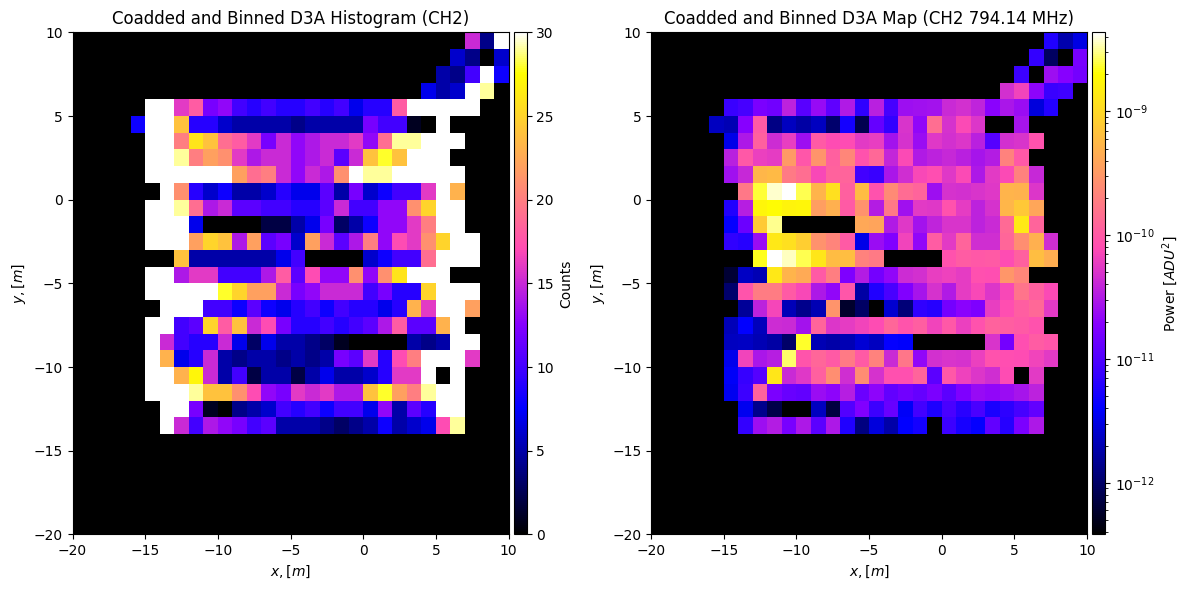

In [307]:
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(12,6))
ax1.set_title('Coadded and Binned D3A Histogram (CH{})'.format(2))
ax2.set_title('Coadded and Binned D3A Map (CH{} {:.2f} MHz)'.format(2,nfconcat.freq[15]))
im1=ax1.pcolormesh(testbeam.x_edges_grid,testbeam.y_edges_grid,testbeam.histogram_LC[:,:,2,0].T,\
                   clim=(0,30),cmap=cm.gnuplot2)#,edgecolors='k')
im2=ax2.pcolormesh(testbeam.x_edges_grid,testbeam.y_edges_grid,testbeam.V_LC[:,:,15,2,0].T,\
                   cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
images=[im1,im2]
cbarlabels=['Counts','Power [$ADU^2$]']
for i,ax in enumerate([ax1,ax2]):
    #ax.plot(testbeam.x_centers_grid,testbeam.y_centers_grid,'c.',markersize=2,alpha=0.3)
    ax.set_facecolor('k')
    ax.set_xlabel('$x,[m]$')
    ax.set_ylabel('$y, [m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig.colorbar(images[i],cax=cax)
    cbar.set_label(cbarlabels[i])
tight_layout()


In [308]:
#create xvect [xgrid] and yvect [ygrid], coord vectors for spatial x and y over telescope FOV in cartesian:
ccmin,ccmax,ccres=[-20,10,0.3]
xedges,yedges=(cedges([ccmin,ccmax,ccres]),cedges([ccmin,ccmax,ccres]))
xedgesgrid,yedgesgrid=np.meshgrid(xedges,yedges)
xcenters,ycenters=(cedges([ccmin,ccmax,ccres])[:-1]+ccres/2.0,cedges([ccmin,ccmax,ccres])[:-1]+ccres/2.0)
xcentersgrid,ycentersgrid=np.meshgrid(xcenters,ycenters)
print('edges grids dims:',xedgesgrid.shape,yedgesgrid.shape)
print('centers grids dims:',xcentersgrid.shape,ycentersgrid.shape)

edges grids dims: (101, 101) (101, 101)
centers grids dims: (100, 100) (100, 100)


hist grid dims: (100, 100)


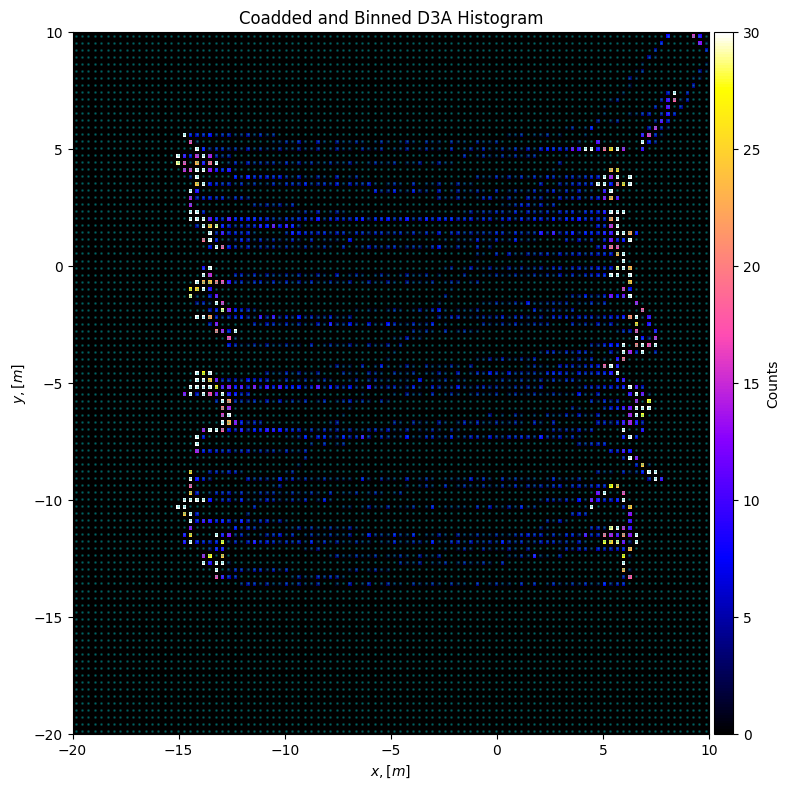

In [309]:
#get the x,y coords from time domain data:
x,y=[nfconcat.drone_xyz_LC_interp[:,0],nfconcat.drone_xyz_LC_interp[:,1]]
hist,xbins,ybins=np.histogram2d(x=x,y=y,bins=[xedges,yedges])
print('hist grid dims:',hist.shape)

fig,ax=subplots(nrows=1,ncols=1,figsize=(8,8))
im1=ax.pcolormesh(xedgesgrid,yedgesgrid,hist.T,clim=(0,30),cmap=cm.gnuplot2,edgecolors='k')
ax.plot(xcentersgrid,ycentersgrid,'c.',markersize=2,alpha=0.3)
ax.set_facecolor('k')
ax.set_title('Coadded and Binned D3A Histogram')
ax.set_xlabel('$x,[m]$')
ax.set_ylabel('$y, [m]$')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(im1,cax=cax)
cbar.set_label('Counts')
tight_layout()

(25536, 1024, 4)
(100, 100, 1024, 4)


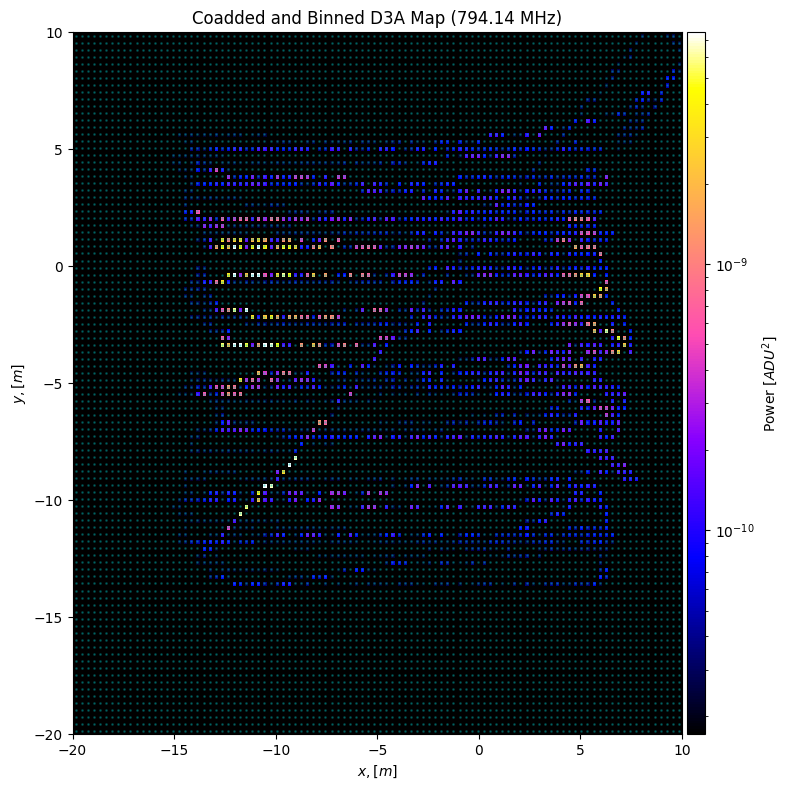

In [310]:
print(nfconcat.V_bgsub.shape)
V_rm=np.NAN*np.ones((xcentersgrid.shape[0],xcentersgrid.shape[1],nfconcat.V.shape[1],nfconcat.V.shape[2]))

xnz,ynz=np.where(hist!=0)
#print(xnz,ynz)
for i in range(len(xnz)):
    j,k=[xnz[i],ynz[i]]
    xacc=np.intersect1d(np.where(xedges[j]<=x),np.where(xedges[j+1]>x))
    yacc=np.intersect1d(np.where(yedges[k]<=y),np.where(yedges[k+1]>y))
    tacc=np.intersect1d(xacc,yacc)
    #print(i)
    #print(tacc)
    V_rm[j,k,:,:]=np.nanmean(nfconcat.V[tacc],axis=0)

fig,ax=subplots(nrows=1,ncols=1,figsize=(8,8))
im1=ax.pcolormesh(xedgesgrid,yedgesgrid,V_rm[:,:,15,2].T,cmap=cm.gnuplot2,norm=LogNorm(),edgecolors='k')
ax.plot(xcentersgrid,ycentersgrid,'c.',markersize=2,alpha=0.3)
ax.set_facecolor('k')
ax.set_title('Coadded and Binned D3A Map ({:.2f} MHz)'.format(nfconcat.freq[15]))
ax.set_xlabel('$x,[m]$')
ax.set_ylabel('$y, [m]$')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(im1,cax=cax)
cbar.set_label('Power [$ADU^2$]')
tight_layout()

print(V_rm.shape)